In [2]:
import os.path as op
import os

import mne_bids
import numpy as np
import shutil
import scipy as sp

import nibabel as nib
from nilearn.plotting import plot_anat

import mne
from mne_bids import (BIDSPath, write_raw_bids, write_anat,
                      get_anat_landmarks, read_raw_bids,
                      search_folder_for_text, print_dir_tree,
                      template_to_head)

In [2]:
T1 = nib.load("/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/fs_subjects/ca/mri/T1.mgz")

Text(-80.0, -40.0, 'PC')

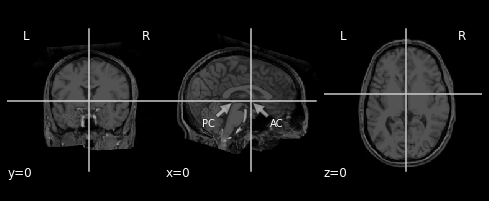

In [3]:
fig = plot_anat(T1, cut_coords=(0, 0, 0))
fig.axes['x'].ax.annotate('AC', (2., -2.), (30., -40.), color='w',
                          arrowprops=dict(facecolor='w', alpha=0.5))
fig.axes['x'].ax.annotate('PC', (-31., -2.), (-80., -40.), color='w',
                          arrowprops=dict(facecolor='w', alpha=0.5))

In [3]:
raw_data_dir = "/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/faces_noise"
bids_dir = "/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS"
fs_subjects_dir = "/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/fs_subjects"

In [23]:
for subject in os.listdir(f"{raw_data_dir}/data/"):
    if not subject.startswith("."):
        clean_bids_path = BIDSPath(root=bids_dir, subject=subject, session="01", datatype="ieeg", task="clean")
        noisy_bids_path = BIDSPath(root=bids_dir, subject=subject, session="01", datatype="ieeg", task="noisy")

        clean_data = sp.io.loadmat(f"{raw_data_dir}/data/{subject}/{subject}_faceshouses.mat")
        noisy_data = sp.io.loadmat(f"{raw_data_dir}/data/{subject}/{subject}_fhnoisy.mat")
        locs = sp.io.loadmat(f"{raw_data_dir}/locs/{subject}_xslocs.mat")["locs"]
        T1 = nib.load(f"{fs_subjects_dir}/{subject}/mri/T1.mgz")

        clean_stim = clean_data["stim"]
        clean_stim[clean_stim == 101] = 0 # Set inter-stimulus intervals to 0
        clean_stim[(0 < clean_stim) & (clean_stim <= 50)] = 1  # Set houses to trigger 1
        clean_stim[clean_stim > 50] = 2  # Set faces to trigger 2
        clean_events_id = {"house/clean": 1, "face/clean": 2}

        clean_changes = np.where(np.roll(clean_stim,1)!=clean_stim)[0]
        clean_stim_onsets, stim_offsets = clean_changes[0::2], clean_changes[1::2]
        clean_events = np.vstack((clean_stim_onsets, np.zeros_like(clean_stim_onsets), np.squeeze(clean_stim[clean_stim_onsets]))).T

        noisy_stim = np.squeeze(noisy_data["stim"])

        noisy_changes = np.where(np.roll(noisy_stim,1)!=noisy_stim)[0]
        noisy_stim_onsets = noisy_changes[(noisy_stim[noisy_changes] != 0)]
        noisy_events = np.vstack((noisy_stim_onsets, np.zeros_like(noisy_stim_onsets), np.squeeze(noisy_data["tr_fh"])[noisy_stim[noisy_stim_onsets]-1]+10)).T
        noisy_events_id = {"house/noisy": 11, "face/noisy": 12}

        montage = mne.channels.make_dig_montage({str(i): locs[i,...] / 1000 for i in range(locs.shape[0])}, coord_frame="mri")
        mri_mni_trans = mne.read_talxfm(subject, fs_subjects_dir)
        montage.apply_trans(mri_mni_trans)
        montage.add_mni_fiducials(subject, fs_subjects_dir)
        trans = mne.coreg.estimate_head_mri_t(subject, fs_subjects_dir)

        clean_info = mne.create_info(clean_data["data"].shape[1], sfreq=clean_data["srate"], ch_types="ecog")
        noisy_info = mne.create_info(noisy_data["data"].shape[1], sfreq=noisy_data["srate"], ch_types="ecog")
        clean_info["line_freq"], noisy_info["line_freq"] = 60, 60

        clean_raw = mne.io.RawArray(clean_data["data"].T/1e6, clean_info)
        noisy_raw = mne.io.RawArray(noisy_data["data"].T/1e6, noisy_info)
        clean_raw.set_montage(montage)
        noisy_raw.set_montage(montage)

        landmarks = get_anat_landmarks(
            T1,  # path to the MRI scan
            info=clean_raw.info,  # the MEG data file info from the same subject as the MRI
            trans=trans,  # our transformation matrix
            fs_subject=subject,  # FreeSurfer subject
            fs_subjects_dir=fs_subjects_dir,  # FreeSurfer subjects directory
        )
        
        anat_path = mne_bids.BIDSPath(root=bids_dir, subject=subject, session="01", suffix="T1w")

        write_anat(T1, anat_path, overwrite=True, landmarks=landmarks)
        write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
        write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)

Creating RawArray with float64 data, n_channels=41, n_times=268400
    Range : 0 ... 268399 =      0.000 ...   268.399 secs
Ready.
Creating RawArray with float64 data, n_channels=41, n_times=666240
    Range : 0 ... 666239 =      0.000 ...   666.239 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/anat/sub-ap_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/ieeg/sub-ap_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/ieeg/sub-ap_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/clean', 'house/clean']
Writing '/Users/daniel/Documents/Coding_Projects/G

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/sub-ap_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/sub-ap_ses-01_scans.tsv entry with ieeg/sub-ap_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/ieeg/sub-ap_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/ieeg/sub-ap_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/ieeg/sub-ap_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/sub-ap_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ap/ses-01/sub-ap_ses-01_scans.tsv entry with ieeg/sub-ap_ses-01_task-noisy_ieeg.vhdr.
Creating RawArray with float64 data, n_channels=60, n_times=271400
    Range : 0 ... 271399 =      0.000 ...   271.399 secs
Ready.
Creating RawArray with float64 data, n_channels=60, n_times=672240
    Range : 0 ... 672239 =      0.000 ...   672.239 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/anat/sub-ja_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/ieeg/sub-ja_se

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/sub-ja_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/sub-ja_ses-01_scans.tsv entry with ieeg/sub-ja_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/ieeg/sub-ja_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/ieeg/sub-ja_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/ieeg/sub-ja_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/sub-ja_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ja/ses-01/sub-ja_ses-01_scans.tsv entry with ieeg/sub-ja_ses-01_task-noisy_ieeg.vhdr.
Creating RawArray with float64 data, n_channels=50, n_times=271360
    Range : 0 ... 271359 =      0.000 ...   271.359 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=672280
    Range : 0 ... 672279 =      0.000 ...   672.279 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/anat/sub-ca_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/ieeg/sub-ca_se

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/sub-ca_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/sub-ca_ses-01_scans.tsv entry with ieeg/sub-ca_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/ieeg/sub-ca_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/ieeg/sub-ca_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/ieeg/sub-ca_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/sub-ca_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ca/ses-01/sub-ca_ses-01_scans.tsv entry with ieeg/sub-ca_ses-01_task-noisy_ieeg.vhdr.
Creating RawArray with float64 data, n_channels=39, n_times=271400
    Range : 0 ... 271399 =      0.000 ...   271.399 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=672280
    Range : 0 ... 672279 =      0.000 ...   672.279 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/anat/sub-wc_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/ieeg/sub-wc_se

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/sub-wc_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/sub-wc_ses-01_scans.tsv entry with ieeg/sub-wc_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/ieeg/sub-wc_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/ieeg/sub-wc_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/ieeg/sub-wc_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/sub-wc_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-wc/ses-01/sub-wc_ses-01_scans.tsv entry with ieeg/sub-wc_ses-01_task-noisy_ieeg.vhdr.
Creating RawArray with float64 data, n_channels=58, n_times=271400
    Range : 0 ... 271399 =      0.000 ...   271.399 secs
Ready.
Creating RawArray with float64 data, n_channels=58, n_times=672240
    Range : 0 ... 672239 =      0.000 ...   672.239 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/anat/sub-zt_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/ieeg/sub-zt_se

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/sub-zt_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/sub-zt_ses-01_scans.tsv entry with ieeg/sub-zt_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/ieeg/sub-zt_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/ieeg/sub-zt_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/ieeg/sub-zt_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/sub-zt_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-zt/ses-01/sub-zt_ses-01_scans.tsv entry with ieeg/sub-zt_ses-01_task-noisy_ieeg.vhdr.
Creating RawArray with float64 data, n_channels=39, n_times=251240
    Range : 0 ... 251239 =      0.000 ...   251.239 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=672240
    Range : 0 ... 672239 =      0.000 ...   672.239 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/anat/sub-ha_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/ieeg/sub-ha_se

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/sub-ha_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/sub-ha_ses-01_scans.tsv entry with ieeg/sub-ha_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/ieeg/sub-ha_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/ieeg/sub-ha_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/ieeg/sub-ha_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/sub-ha_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-ha/ses-01/sub-ha_ses-01_scans.tsv entry with ieeg/sub-ha_ses-01_task-noisy_ieeg.vhdr.
Creating RawArray with float64 data, n_channels=58, n_times=271400
    Range : 0 ... 271399 =      0.000 ...   271.399 secs
Ready.
Creating RawArray with float64 data, n_channels=58, n_times=672280
    Range : 0 ... 672279 =      0.000 ...   672.279 secs
Ready.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/anat/sub-mv_ses-01_T1w.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/ieeg/sub-mv_se

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:52: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(clean_raw, clean_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=clean_events, event_id=clean_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/sub-mv_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/sub-mv_ses-01_scans.tsv entry with ieeg/sub-mv_ses-01_task-clean_ieeg.vhdr.
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/participants.json'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/ieeg/sub-mv_ses-01_space-ACPC_electrodes.tsv'...
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/ieeg/sub-mv_ses-01_space-ACPC_coordsystem.json'...
Used Annotations descriptions: ['face/noisy', 'house/noisy']
Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/ieeg/sub-mv_ses-01_task-noisy_events.tsv'...
Writin

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_48857/1135924615.py:53: RuntimeWarning: Encountered data in "double" format. Converting to float32.
  write_raw_bids(noisy_raw, noisy_bids_path, allow_preload=True, format="BrainVision", acpc_aligned=True, overwrite=True, events_data=noisy_events, event_id=noisy_events_id, montage=montage)


Writing '/Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/sub-mv_ses-01_scans.tsv'...
Wrote /Users/daniel/Documents/Coding_Projects/GitHub/NMA-FacesHouses/data/BIDS/sub-mv/ses-01/sub-mv_ses-01_scans.tsv entry with ieeg/sub-mv_ses-01_task-noisy_ieeg.vhdr.


In [53]:
mne.viz.plot_alignment(clean_raw.info, subject="fsaverage", subjects_dir=fs_subjects_dir, trans="fsaverage",
                       surfaces="brain", coord_frame="mri", ecog=True, dig="fiducials")

Channel types::	ecog: 58


In [49]:
subject = "zt"

clean_bids_path = BIDSPath(root=bids_dir, subject=subject, session="01", datatype="ieeg", task="clean")
noisy_bids_path = BIDSPath(root=bids_dir, subject=subject, session="01", datatype="ieeg", task="noisy")

clean_data = sp.io.loadmat(f"{raw_data_dir}/data/{subject}/{subject}_faceshouses.mat")
noisy_data = sp.io.loadmat(f"{raw_data_dir}/data/{subject}/{subject}_fhnoisy.mat")
locs = sp.io.loadmat(f"{raw_data_dir}/locs/{subject}_xslocs.mat")["locs"]
T1 = nib.load(f"{fs_subjects_dir}/{subject}/mri/T1.mgz")

clean_stim = clean_data["stim"]
clean_stim[clean_stim == 101] = 0 # Set inter-stimulus intervals to 0
clean_stim[(0 < clean_stim) & (clean_stim <= 50)] = 1  # Set houses to trigger 1
clean_stim[clean_stim > 50] = 2  # Set faces to trigger 2
clean_events_id = {"house/clean": 1, "face/clean": 2}

clean_changes = np.where(np.roll(clean_stim,1)!=clean_stim)[0]
clean_stim_onsets, stim_offsets = clean_changes[0::2], clean_changes[1::2]
clean_events = np.vstack((clean_stim_onsets, np.zeros_like(clean_stim_onsets), np.squeeze(clean_stim[clean_stim_onsets]))).T

noisy_stim = np.squeeze(noisy_data["stim"])

noisy_changes = np.where(np.roll(noisy_stim,1)!=noisy_stim)[0]
noisy_stim_onsets = noisy_changes[(noisy_stim[noisy_changes] != 0)]
noisy_events = np.vstack((noisy_stim_onsets, np.zeros_like(noisy_stim_onsets), np.squeeze(noisy_data["tr_fh"])[noisy_stim[noisy_stim_onsets]-1]+10)).T
noisy_events_id = {"house/noisy": 11, "face/noisy": 12}

montage = mne.channels.make_dig_montage({str(i): locs[i,...] / 1000 for i in range(locs.shape[0])}, coord_frame="mri")
mri_mni_trans = mne.read_talxfm(subject, fs_subjects_dir)
montage.apply_trans(mri_mni_trans)
montage.add_mni_fiducials(fs_subjects_dir)
trans = mne.coreg.estimate_head_mri_t(subject, fs_subjects_dir)

clean_info = mne.create_info(clean_data["data"].shape[1], sfreq=clean_data["srate"], ch_types="ecog")
noisy_info = mne.create_info(noisy_data["data"].shape[1], sfreq=noisy_data["srate"], ch_types="ecog")
clean_info["line_freq"], noisy_info["line_freq"] = 60, 60

clean_raw = mne.io.RawArray(clean_data["data"].T/1e6, clean_info)
noisy_raw = mne.io.RawArray(noisy_data["data"].T/1e6, noisy_info)
clean_raw.set_montage(montage)
noisy_raw.set_montage(montage)

landmarks = get_anat_landmarks(
T1,  # path to the MRI scan
info=clean_raw.info,  # the MEG data file info from the same subject as the MRI
trans=trans,  # our transformation matrix
fs_subject=subject,  # FreeSurfer subject
fs_subjects_dir=fs_subjects_dir,  # FreeSurfer subjects directory
)

anat_path = mne_bids.BIDSPath(root=bids_dir, subject=subject, session="01", suffix="T1w")

Creating RawArray with float64 data, n_channels=58, n_times=271400
    Range : 0 ... 271399 =      0.000 ...   271.399 secs
Ready.
Creating RawArray with float64 data, n_channels=58, n_times=672240
    Range : 0 ... 672239 =      0.000 ...   672.239 secs
Ready.


In [50]:
mne.viz.plot_alignment(clean_raw.info, subject=subject, subjects_dir=fs_subjects_dir, trans=trans,
                       surfaces="brain", coord_frame="mri", ecog=True, dig="fiducials")

Channel types::	ecog: 58


In [38]:
#montage = clean_raw.get_montage()
#montage.apply_trans(trans)

mri_mni_trans = mne.read_talxfm(subject, fs_subjects_dir)
montage.apply_trans(mri_mni_trans)
clean_raw.set_montage(montage)

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_49807/708140129.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  clean_raw.set_montage(montage)


<RawArray | 41 x 268400 (268.4 s), ~84.0 MB, data loaded>

In [39]:
montage.get_positions()

{'ch_pos': OrderedDict([('0', array([-0.00151601,  0.0542165 , -0.03242715])),
              ('1', array([-0.03396434,  0.05558053, -0.01426291])),
              ('2', array([ 0.00230228,  0.03572301, -0.04066207])),
              ('3', array([-0.00431974,  0.03006536, -0.04451328])),
              ('4', array([-0.01398581,  0.02668284, -0.04138145])),
              ('5', array([-0.02378507,  0.02422926, -0.03851308])),
              ('6', array([-0.03941642,  0.01458899, -0.03314438])),
              ('7', array([-0.04796878, -0.03896732, -0.04813212])),
              ('8', array([-0.04210799, -0.02999059, -0.04818123])),
              ('9', array([-0.03284147, -0.0238213 , -0.05210348])),
              ('10', array([-0.0260574 , -0.01743189, -0.05592315])),
              ('11', array([-0.01978003, -0.00794184, -0.05615086])),
              ('12', array([-0.01813191,  0.00207122, -0.05770938])),
              ('13', array([-0.02246993,  0.01138114, -0.05568054])),
              ('14',